# Tutorial 04

## partial-sky ABS pipeline (with noise)

To validate the ABS method we have simulated a few foregrounds maps including dust and synchrotron at 30, 95, 150 and 353 GHz, using PySM package. CAMB is utilized to predict the CMB power spectra with respect to the Planck best fit 2018 results, from which random realizations of CMB anisotropies are obtained. For the tensor-to-scalar ratio, we set it as 0.05 for the generation of CMB maps. White noise maps are generated according to the Planck level.

Measurement uncertainties are prepared as white noise.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from afra.tools.ps_estimator import pstimator
from dynesty import utils as dyfunc
from getdist import plots, MCSamples
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
NSAMP = 10  # size of resampling
PSBIN = 40
NPIX = 12*NSIDE**2
APOSCALE = 6.
LMIN = 40
LMAX = 200

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

vmap30 = hp.read_map('./data/plkvar_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap30 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap30.shape[1]))*np.sqrt(vmap30)
nmap95 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap95.shape[1]))*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap150.shape[1]))*np.sqrt(vmap150)
nmap353 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap353.shape[1]))*np.sqrt(vmap353)

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)

fullbeam = dict()
fullbeam[30] = 0.5*np.pi/180.
fullbeam[95] = 0.3*np.pi/180.
fullbeam[150] = 0.2*np.pi/180.
fullbeam[353] = 0.08*np.pi/180.

fullmap = dict()
fullmap[30] = hp.smoothing(map30f+mapcmb,fwhm=fullbeam[30],verbose=0) + nmap30[0]
fullmap[95] = hp.smoothing(map95f+mapcmb,fwhm=fullbeam[95],verbose=0) + nmap95[0]
fullmap[150] = hp.smoothing(map150f+mapcmb,fwhm=fullbeam[150],verbose=0) + nmap150[0]
fullmap[353] = hp.smoothing(map353f+mapcmb,fwhm=fullbeam[353],verbose=0) + nmap353[0]

fullnoise = dict()
fullnoise[30] = nmap30[1:]
fullnoise[95] = nmap95[1:]
fullnoise[150] = nmap150[1:]
fullnoise[353] = nmap353[1:]

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=False)

est = pstimator(nside=NSIDE,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)
est.targets = 'T'
cmb_dl_t = est.autoBP(mapcmb)
est.targets = 'EB'
cmb_dl_eb = est.autoBP(mapcmb)
cmb_dl = np.vstack([cmb_dl_t[0],cmb_dl_t[1],cmb_dl_eb[1],cmb_dl_eb[2]])

#### run ABS pipeline

CPU times: user 1h 9min 46s, sys: 13.1 s, total: 1h 9min 59s
Wall time: 9min 4s


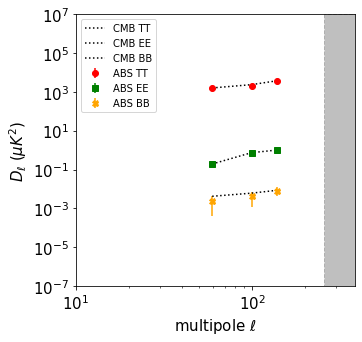

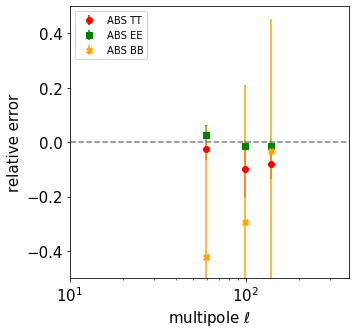

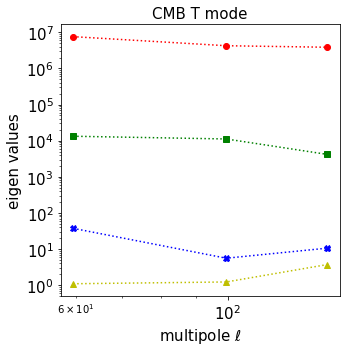

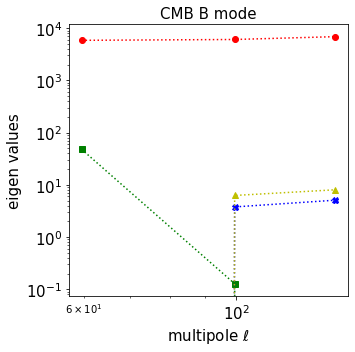

In [2]:
%%time

pipeline = af.abspipe(fullmap,mask=mask,noises=fullnoise,fwhms=fullbeam,targets='T')
pipeline.debug = True
rslt_t, info_t = pipeline.run(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,shift=10.,threshold=1.)
pipeline.targets = 'EB'
rslt_eb, info_eb = pipeline.run(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,shift=10.,threshold=1.)

fig,ax = plt.subplots(figsize=(5,5))

ax.plot(cmb_dl[0],cmb_dl[1],color='black',linestyle=':',label=r'CMB TT')
ax.plot(cmb_dl[0],cmb_dl[2],color='black',linestyle=':',label=r'CMB EE')
ax.plot(cmb_dl[0],cmb_dl[3],color='black',linestyle=':',label=r'CMB BB')

ax.errorbar(rslt_t[0],rslt_t[1],yerr=rslt_t[2],
            color='red',fmt='o',label=r'ABS TT')
ax.errorbar(rslt_eb[0],rslt_eb[1],yerr=rslt_eb[3],
            color='green',fmt='s',label=r'ABS EE')
ax.errorbar(rslt_eb[0],rslt_eb[2],yerr=rslt_eb[4],
            color='orange',fmt='X',label=r'ABS BB')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((10,3*NSIDE))

fig,ax = plt.subplots(figsize=(5,5))

ax.errorbar(rslt_t[0],(rslt_t[1]-cmb_dl[1])/cmb_dl[1],yerr=rslt_t[2]/cmb_dl[1],
            color='red',fmt='o',label=r'ABS TT')
ax.errorbar(rslt_eb[0],(rslt_eb[1]-cmb_dl[2])/cmb_dl[2],yerr=rslt_eb[3]/cmb_dl[2],
            color='green',fmt='s',label=r'ABS EE')
ax.errorbar(rslt_eb[0],(rslt_eb[2]-cmb_dl[3])/cmb_dl[3],yerr=rslt_eb[4]/cmb_dl[3],
            color='orange',fmt='X',label=r'ABS BB')
ax.plot((1,3*NSIDE),(0,0),color='grey',linestyle='--')

ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'relative error',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((-0.5,0.5))
ax.set_xlim((10,3*NSIDE))

fig,ax = plt.subplots(figsize=(5,5))
freq_list = [30,95,150,353]
eigens = np.empty((len(freq_list),len(rslt_t[0])))
for i in range(eigens.shape[1]):
    eigens[:,i] = info_t['T'][i][0]
ax.plot(rslt_t[0],eigens[0],linestyle=':',color='r',marker='o')
ax.plot(rslt_t[0],eigens[1],linestyle=':',color='g',marker='s')
ax.plot(rslt_t[0],eigens[2],linestyle=':',color='b',marker='X')
ax.plot(rslt_t[0],eigens[3],linestyle=':',color='y',marker='^')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'multipole $\ell$', fontsize=15)
ax.set_ylabel(r'eigen values', fontsize=15)
ax.set_title('CMB T mode', fontsize=15)
ax.tick_params(axis='both', labelsize=15)


fig,ax = plt.subplots(figsize=(5,5))
freq_list = [30,95,150,353]
eigens = np.empty((len(freq_list),len(rslt_eb[0])))
for i in range(eigens.shape[1]):
    eigens[:,i] = info_eb['B'][i][0] 
ax.plot(rslt_eb[0],eigens[0],linestyle=':',color='r',marker='o')
ax.plot(rslt_eb[0],eigens[1],linestyle=':',color='g',marker='s')
ax.plot(rslt_eb[0],eigens[2],linestyle=':',color='b',marker='X')
ax.plot(rslt_eb[0],eigens[3],linestyle=':',color='y',marker='^')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'multipole $\ell$', fontsize=15)
ax.set_ylabel(r'eigen values', fontsize=15)
ax.set_title('CMB B mode', fontsize=15)
ax.tick_params(axis='both', labelsize=15)

#### post-analysis with `tpfit_simple` & `tpfit_hl`

in real application, we need to include the cosmic-variance,
ABS only considers measurement noise

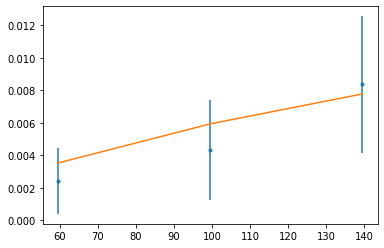

In [3]:
from afra.tools.bg_models import cambmodel
from afra.methods.tpfit import tpfit_hl, tpfit_gauss
from dynesty import plotting as dyplot

b = cambmodel(freqlist=[95],targets='B',mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)
fiducial = b.bandpower()

plt.errorbar(rslt_eb[0],rslt_eb[2],rslt_eb[4],fmt='.')
plt.plot(rslt_eb[0],fiducial[0,:,0,0])

size = fiducial.shape[1]
signal = np.zeros((1,size,1,1),dtype=np.float32)
for l in range(size):
    signal[0,l,0,0] = rslt_eb[2][l]

cov = np.diag(rslt_eb[4]**2)

iter: 1669 | +400 | bound: 1 | nc: 1 | ncall: 14926 | eff(%): 13.862 | loglstar:   -inf < -0.029 <    inf | logz: -3.147 +/-  0.102 | dlogz:  0.001 >  0.409                                          

Removed no burn in
Removed no burn in


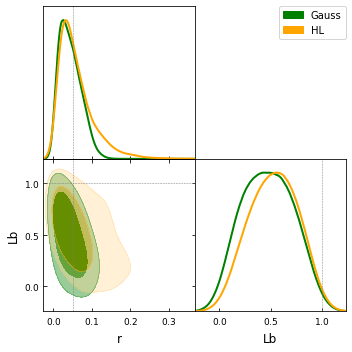

In [4]:
KWARGS = {'nlive':400}
truths = [0.05,1.]
names = ['r','Lb']

pipeline = tpfit_gauss(signal,cov,background=b,foreground=None)
rslt1 = pipeline.run(kwargs=KWARGS)

pipeline = tpfit_hl(signal,fiducial,np.zeros_like(signal),cov,background=b,foreground=None)
rslt2 = pipeline.run(kwargs=KWARGS)

samples, weights = rslt1.samples, np.exp(rslt1.logwt - rslt1.logz[-1])
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')

samples, weights = rslt2.samples, np.exp(rslt2.logwt - rslt2.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

g = plots.get_subplot_plotter(width_inch=5)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':'2', 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

end